In [1]:
import pandas as pd

import seaborn as sns
import numpy as np

/tmp/ipykernel_16064/2993202063.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# STEP 1: READING AND PROCESSING DATA
Dataset used: https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset

In [2]:
dataset = pd.read_csv("./data/crop.rec.csv")
dataset

,N,P,K,temperature,humidity,ph,rainfall,label,season
0,90,42,43,20.879744,82.002744,6.502985,202.935536,Rice,Kharif
1,85,58,41,21.770462,80.319644,7.038096,226.655537,Rice,Kharif
2,60,55,44,23.004459,82.320763,7.840207,263.964248,Rice,Kharif
3,74,35,40,26.491096,80.158363,6.980401,242.864034,Rice,Kharif
4,78,42,42,20.130175,81.604873,7.628473,262.717340,Rice,Kharif
...,...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee,Rabi
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee,Kharif
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee,Rabi
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee,Kharif


In [3]:
dataset.isna().sum().sum()

0

There are no null values!

In [4]:
labels_unique = list(set(dataset["label"]))
dataset["label"] = dataset["label"].map(lambda x: labels_unique.index(x))
labels_unique

['jute',
 'coconut',
 'chickpea',
 'apple',
 'mothbeans',
 'Rice',
 'Maize',
 'kidneybeans',
 'banana',
 'orange',
 'coffee',
 'mungbean',
 'blackgram',
 'pomegranate',
 'mango',
 'cotton',
 'muskmelon',
 'pigeonpeas',
 'grapes',
 'papaya',
 'watermelon',
 'lentil']

In [5]:
seasons = ["Rabi", "Kharif"]
dataset["season"] = dataset["season"].map(lambda x: seasons.index(x))

In [6]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

# STEP 2: FEATURE VISUALISATION/SELECTION

,count,mean,std,min,25%,50%,75%,max
N,1760.0,50.540341,36.779162,0.000000,21.000000,37.000000,84.000000,140.000000
P,1760.0,53.518182,33.252847,5.000000,28.000000,51.000000,68.000000,145.000000
K,1760.0,48.578977,51.173600,5.000000,20.000000,32.000000,49.000000,205.000000
temperature,1760.0,25.614251,5.077277,8.825675,22.780645,25.548603,28.636212,43.360515
humidity,1760.0,71.384936,22.405184,14.258040,60.231681,80.432472,90.015634,99.981876
ph,1760.0,6.464833,0.783890,3.504752,5.956308,6.422961,6.931730,9.935091
rainfall,1760.0,103.412477,55.220490,20.211267,64.509670,94.867624,124.704676,298.560117
label,1760.0,10.459659,6.346412,0.000000,5.000000,10.000000,16.000000,21.000000
season,1760.0,0.680682,0.466345,0.000000,0.000000,1.000000,1.000000,1.000000


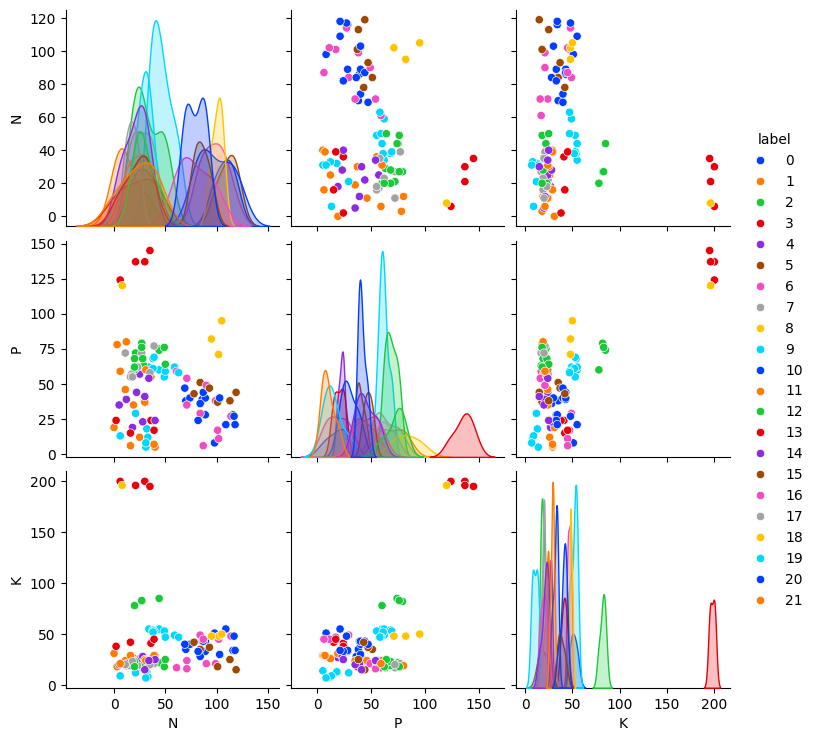

In [7]:
sample = dataset[["N", "P", "K", "label"]].sample(n=100, random_state=42)

sns.pairplot(
    sample,
    hue="label",
    palette="bright",
    # diag_kind="reg",
    # x_vars=["N", "P"],
    # y_vars=["K", "N"]
)


train_dataset.describe().transpose()

In [8]:
X_train = train_dataset.copy().drop("label", axis=1)
X_test = test_dataset.copy().drop("label", axis=1)

In [9]:
Y_train = train_dataset.copy()["label"]
Y_test = test_dataset.copy()["label"]

## Normalizing the Data

In [16]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# X_train

# STEP 3: MODEL SELECTION

In [10]:
### INITIALIZATION ###

from sklearn.metrics import multilabel_confusion_matrix
import time


def run_model(m, fit = True):
    begin = time.time()

    ret = {}
    if fit:
        m.fit(X_train, Y_train)
    ret["cnf"] = multilabel_confusion_matrix(Y_test, m.predict(X_test))
    ret["score"] = m.score(X_test, Y_test)
    ret["time"] = time.time() - begin

    return ret

# 3.1 TESTING VARIOUS CLASSIFICATION MODELS

In [11]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

clf_models = [
    SVC(random_state=42),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
]

for model in clf_models:
    print(f"> testing model: {model.__class__.__name__}")
    scores = run_model(model)
    print(f"  accuracy:   {(scores['score'] * 100):.{3}}%")
    print(f"  time taken: {scores['time']:.{3}}s")
    print("  confusion matrix:")
    print(scores["cnf"].sum(axis=0))

> testing model: SVC
  accuracy:   98.2%
  time taken: 0.137s
  confusion matrix:
[[9232    8]
 [   8  432]]
> testing model: KNeighborsClassifier
  accuracy:   98.0%
  time taken: 0.0666s
  confusion matrix:
[[9231    9]
 [   9  431]]
> testing model: RandomForestClassifier
  accuracy:   99.8%
  time taken: 0.483s
  confusion matrix:
[[9239    1]
 [   1  439]]
> testing model: DecisionTreeClassifier
  accuracy:   98.0%
  time taken: 0.0199s
  confusion matrix:
[[9231    9]
 [   9  431]]


In [12]:
from sklearn.model_selection import GridSearchCV

param_grid_svm = {
    "gamma": [1, 0.2857, 0.1],
    "kernel": ["linear", "rbf", "poly", "sigmoid"],
    "class_weight": ["balanced"],
}

model = GridSearchCV(
    SVC(random_state=42),
    param_grid=param_grid_svm,
    verbose=2,
    cv=8,
    n_jobs=-1,
)

scores = model.fit(X_train, Y_train)

Fitting 8 folds for each of 12 candidates, totalling 96 fits


[CV] END ......class_weight=balanced, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......class_weight=balanced, gamma=1, kernel=linear; total time=   0.1s
[CV] END ......class_weight=balanced, gamma=1, kernel=linear; total time=   0.1s
[CV] END ......class_weight=balanced, gamma=1, kernel=linear; total time=   0.1s[CV] END ......class_weight=balanced, gamma=1, kernel=linear; total time=   0.0s

[CV] END ......class_weight=balanced, gamma=1, kernel=linear; total time=   0.1s
[CV] END ......class_weight=balanced, gamma=1, kernel=linear; total time=   0.1s
[CV] END .........class_weight=balanced, gamma=1, kernel=rbf; total time=   0.6s
[CV] END ......class_weight=balanced, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........class_weight=balanced, gamma=1, kernel=rbf; total time=   0.6s
[CV] END .........class_weight=balanced, gamma=1, kernel=rbf; total time=   0.8s
[CV] END .........class_weight=balanced, gamma=1, kernel=rbf; total time=   0.6s
[CV] END .........class_weig

In [13]:
scores.best_params_

{'class_weight': 'balanced', 'gamma': 1, 'kernel': 'linear'}

In [14]:
svc_model = SVC(class_weight="balanced", gamma=1, kernel="linear")
svc_model.fit(X_train, Y_train)

SVC(class_weight='balanced', gamma=1, kernel='linear')

In [15]:
scores = run_model(svc_model, False)
print(f"  accuracy:   {(scores['score'] * 100):.{3}}%")
print(f"  time taken: {scores['time']:.{3}}s")
print("  confusion matrix:")
print(scores["cnf"].sum(axis=0))

  accuracy:   98.9%
  time taken: 0.0294s
  confusion matrix:
[[9235    5]
 [   5  435]]


In [16]:
from joblib import dump, load

dump(svc_model, "./out/crop.recommend.joblib")

['./out/crop.recommend.joblib']

In [17]:
clf = load("./out/crop.recommend.joblib")

scores = run_model(clf, False)
print(f"  accuracy:   {(scores['score'] * 100):.{3}}%")
print(f"  time taken: {scores['time']:.{3}}s")
print("  confusion matrix:")
print(scores["cnf"].sum(axis=0))

  accuracy:   98.9%
  time taken: 0.0259s
  confusion matrix:
[[9235    5]
 [   5  435]]
